In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statistics
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')


Загрузка данных и EDA

In [3]:
cancer=pd.read_csv('Breast_Cancer.csv', sep=',')
cancer.rename(columns={"Reginol Node Positive":"Regional Node Positive"}, inplace=True)

In [4]:
cancer.head()

Age   Race Marital Status T Stage  N Stage 6th Stage  \
0   68  White        Married       T1      N1       IIA   
1   50  White        Married       T2      N2      IIIA   
2   58  White       Divorced       T3      N3      IIIC   
3   58  White        Married       T1      N1       IIA   
4   47  White        Married       T2      N1       IIB   

               differentiate Grade   A Stage  Tumor Size Estrogen Status  \
0      Poorly differentiated     3  Regional           4        Positive   
1  Moderately differentiated     2  Regional          35        Positive   
2  Moderately differentiated     2  Regional          63        Positive   
3      Poorly differentiated     3  Regional          18        Positive   
4      Poorly differentiated     3  Regional          41        Positive   

  Progesterone Status  Regional Node Examined  Regional Node Positive  \
0            Positive                      24                       1   
1            Positive                      14                       5   
2            Positive                      14                       7   
3            Positive                       2                       1   
4            Positive                       3                       1   

   Survival Months Status  
0               60  Alive  
1               62  Alive  
2               75  Alive  
3               84  Alive  
4               50  Alive

In [5]:
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Regional Node Positive  4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [6]:
def set_style(ax, left=True, bottom=False, axis_grid="y"):
    sns.despine(ax=ax, left=left, bottom=bottom)
    ax.grid(axis=axis_grid, linewidth=0.2, color="black")

In [7]:
colors = [
    "#8187dc", # Light purple
    "#04052e", # Black
    "#97dffc", #Light Blue
]
def count(df, x, ax, main_color=colors[0], hue=None, palette=None):
    
    sns.countplot(data=df, x=x, ax=ax, 
                  color=main_color, saturation=0.8, linewidth=3, edgecolor="black",
                  hue=hue, palette=palette)
    
    
    for container in ax.containers:
        ax.bar_label(container, 
                     color="black", fontsize=10, padding=4)
    
    ax.set_ylabel("")
    ax.set_xlabel(x, fontsize=15)
    ax.tick_params(axis='y', which='both', left=False, right=False)
    
    
    set_style(ax)

In [8]:
def hist(df, x, ax, hue=None, palette=None, main_color=colors[0], second_color=colors[1]):
    
    alpha = 0.8
    if hue:
        alpha = 0.3
    
    sns.histplot(data=df, x=x, ax=ax,
                 hue=hue, palette=palette, 
                 color=main_color, linewidth=3, bins=20, alpha=alpha,
                 kde=True, line_kws={"linewidth":1, "linestyle":"--"}
                )
    ax.lines[0].set_color(second_color)
    
    ax.set_ylabel("Number of observation")
    ax.set_xlabel(x, fontsize="x-large")
    
    set_style(ax)

In [9]:
def strip(df, x, y, ax, palette=[colors[0], colors[2]], hue=None, alpha=1):
    
    sns.stripplot(data=df, x=x, y=y, palette=palette, hue=hue, 
                  linewidth=0.5, size=4, ax=ax, alpha=alpha, edgecolor="black")
    
    ax.set_title(f"{x} vs {y}", pad=0)
    
    set_style(ax, bottom=True)

In [10]:
def cdf_plot(df, x, ax, hue=None, palette=None, main_color=colors[0]):
    
    sns.kdeplot(data=df, x=x, hue=hue, ax=ax, color=main_color,
                palette=palette,
                cumulative=True, warn_singular=False, linewidth=1, common_norm=False)
    
    set_style(ax)

In [11]:
def bar(df, x, y, ax, hue=None, palette=None, color=colors[0], order=None):
    
    sns.barplot(data=df, x=x, y=y, ax=ax, 
                hue=hue, palette=palette, color=color,
                linewidth=2, edgecolor="black", errwidth=2, capsize=0.07,
                order=order)
    
    ax.set_xlabel("")
    
    set_style(ax)

# Categorical Columns -> 11
# Numeric Columns -> 5


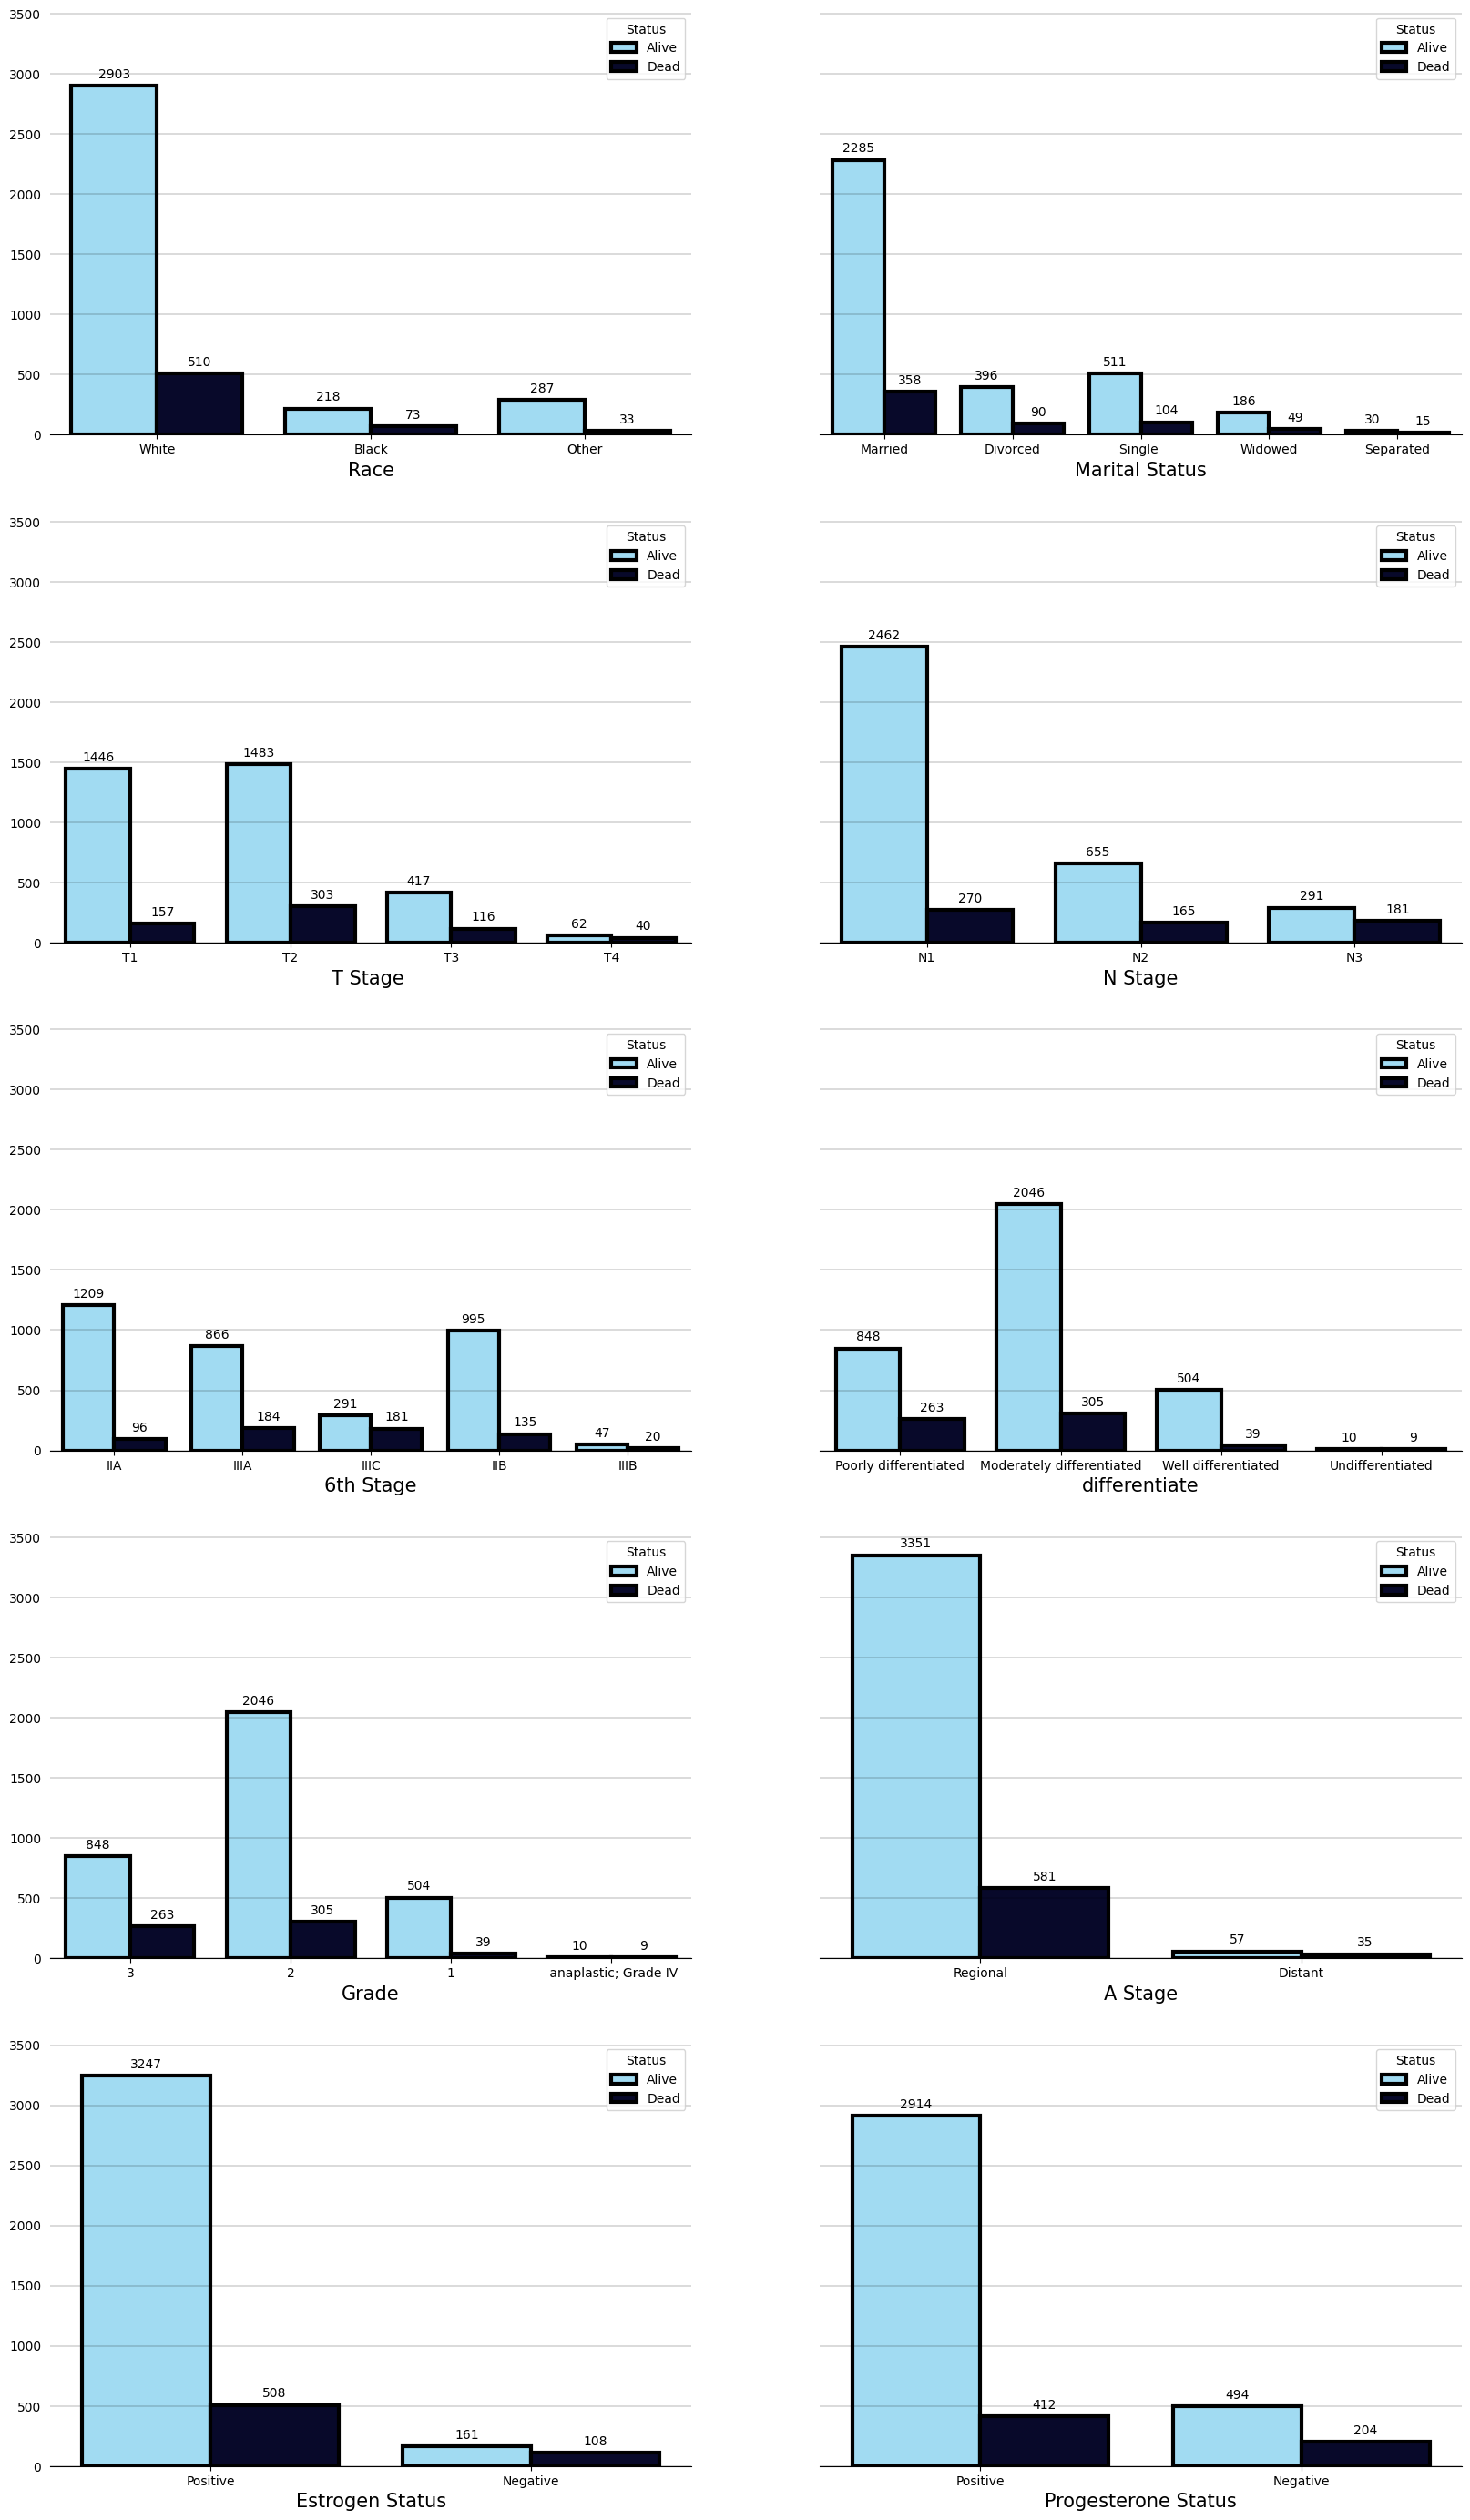

In [12]:
cat_cols = []

for col in cancer.columns:
    if cancer[col].dtype == 'object':
        cat_cols.append(col)
        
print(f"# Categorical Columns -> {len(cat_cols)}")
num_cols = []

for col in cancer.columns:
    if cancer[col].dtype == 'int64':
        num_cols.append(col)
        
print(f"# Numeric Columns -> {len(num_cols)}")
num_cols
cat_cols.remove("Status")
fig, axs = plt.subplots(5, 2, figsize=(20, 35), sharey=True)

for i, col in enumerate(cat_cols):
    ax = axs[i//2][i%2]
    
    count(cancer, col, ax, hue="Status", palette=[colors[2], colors[1]])

    
plt.show()

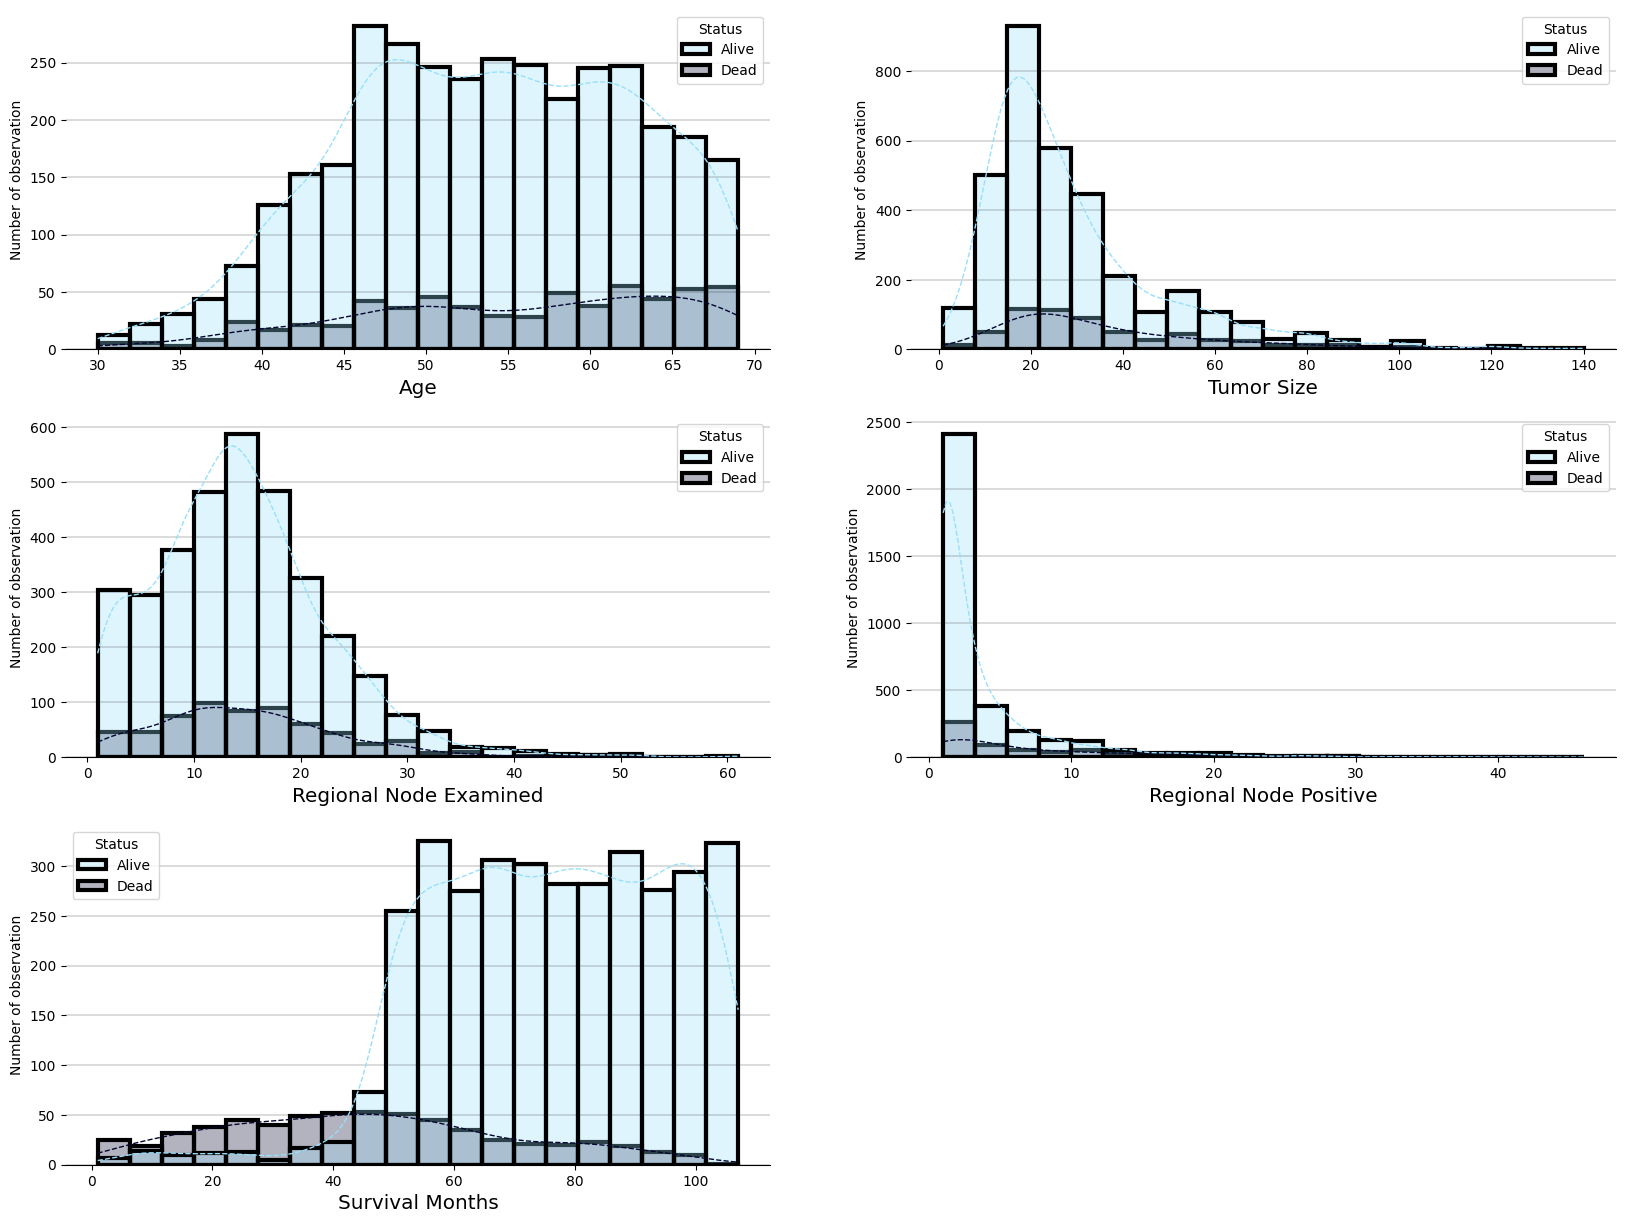

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))

for i, col in enumerate(num_cols):
    ax = axs[i//2][i%2]
    
    hist(cancer, col, ax, hue="Status", palette=[colors[2], colors[1]])
    
fig.delaxes(axs[2,1])
    
plt.show()

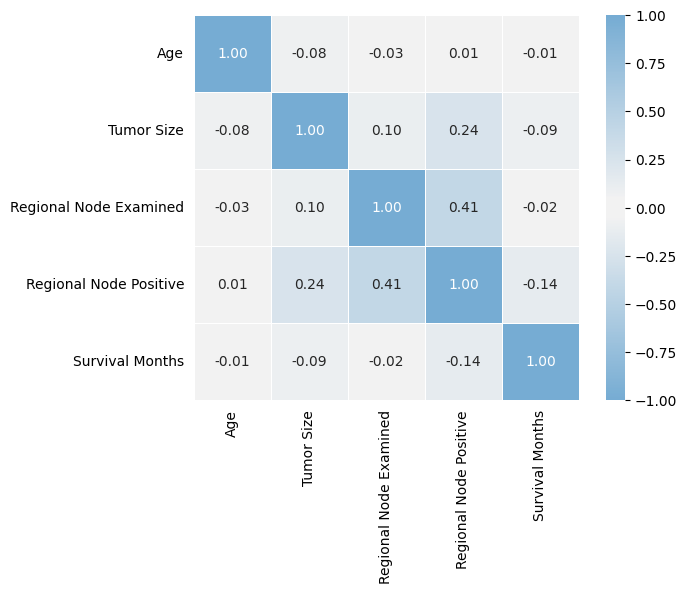

In [14]:
corr = cancer[num_cols].corr()
 
# I create my own palette to use
palette = sns.diverging_palette(236, 236, s=57, l=68, as_cmap=True, sep=15)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

sns.heatmap(corr, annot=True, ax=ax,
               cmap=palette, square=True, linewidth=.5, linecolor="white",
               vmin=-1, vmax=1, fmt=".2f")

# Changes for aesthetics
ax.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left=False,
    right=False
    )

plt.show()

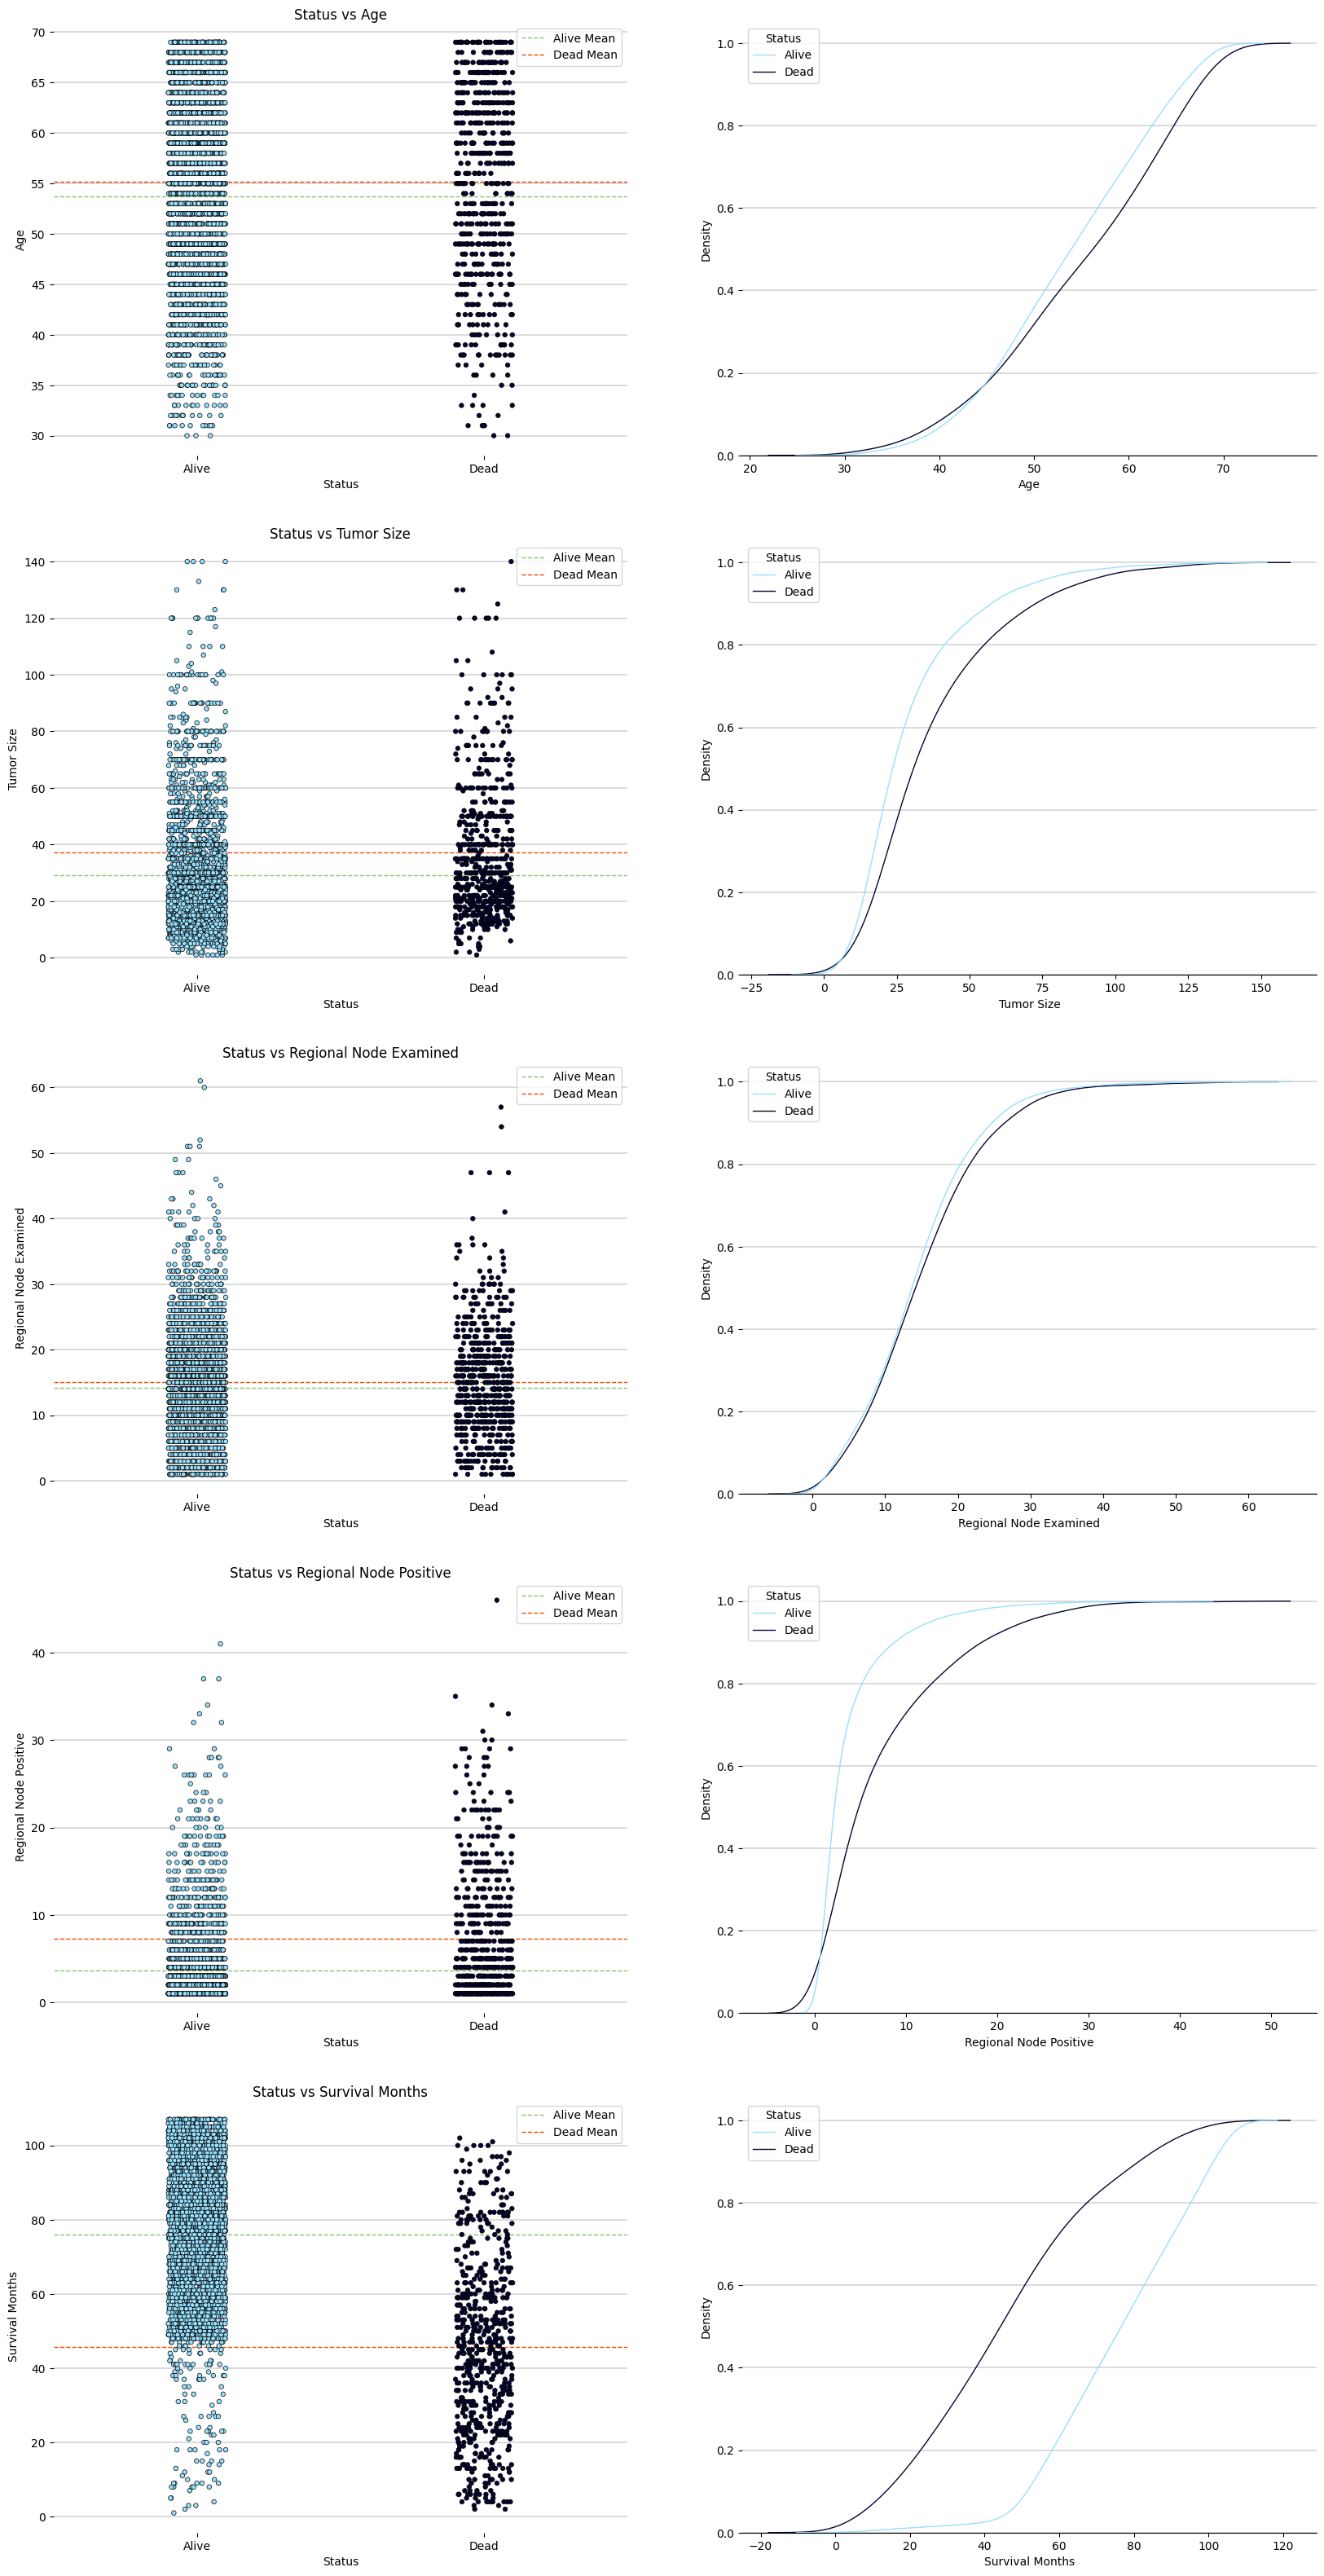

In [15]:
fig, axs = plt.subplots(5, 2, figsize=(20, 40))
i = 0
for col in num_cols:
    
    ax_left = axs[i][0]
    ax_right = axs[i][1]
    
    strip(cancer, "Status", col, ax_left, palette=[colors[2], colors[1]])
    ax_left.axhline(np.mean(cancer[cancer["Status"] == "Alive"][col]), linestyle="--", color="#85C270", linewidth=1, label="Alive Mean")
    ax_left.axhline(np.mean(cancer[cancer["Status"] == "Dead"][col]), linestyle="--", color="#f24b04", linewidth=1, label="Dead Mean")
    ax_left.legend()
    
    cdf_plot(cancer, col, ax_right, hue="Status", palette=[colors[2], colors[1]])

    i += 1
    
    
    
plt.show()

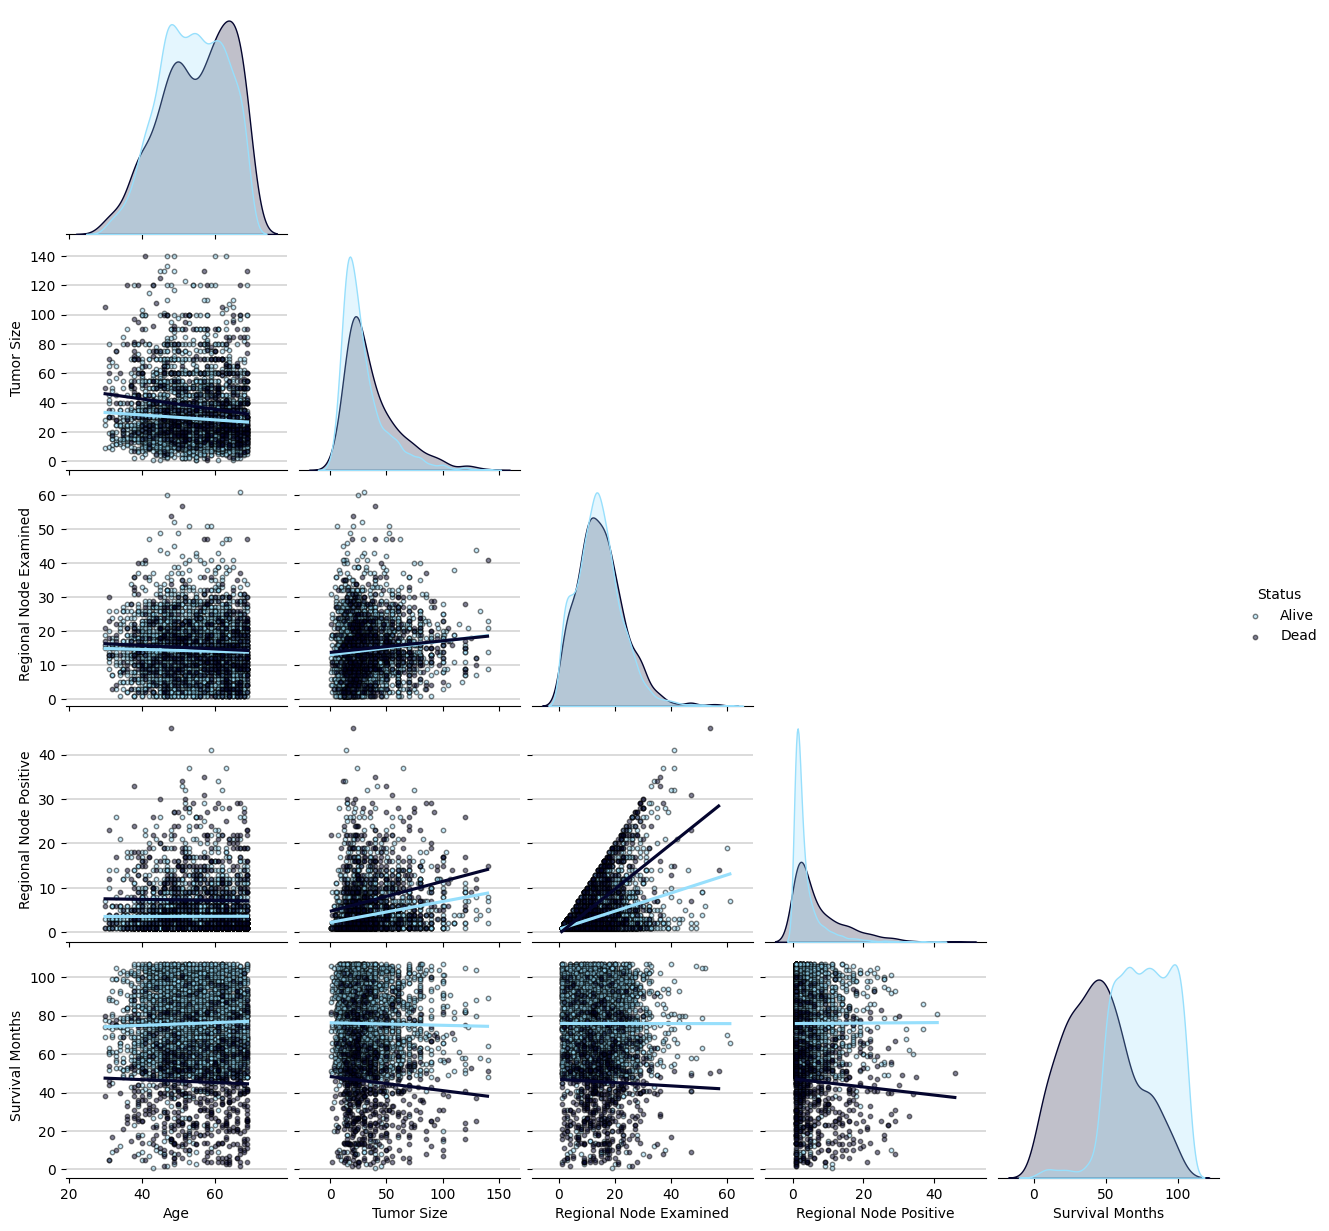

In [16]:
g = sns.pairplot(cancer, hue="Status", palette=[colors[2], colors[1]], corner=True,
            kind="reg", 
            plot_kws={
                "ci":None,
                "scatter_kws": {
                    "alpha":0.5, "s":10, "edgecolor":"black"
                }},
            diag_kws={
                "common_norm":False
            })

for axs in g.axes:
    for ax in axs:
        if ax:
            set_style(ax)

plt.show()

Вручную кодировал категориальные переменные и балансировка

In [17]:
cancercopy = cancer.drop("Race", axis=1)
ros = RandomOverSampler(random_state=1)
y = cancer["Status"]
cancercopy ,y =ros.fit_resample(cancercopy,y)
cancercopy=cancercopy.replace( ['Married' ,'Divorced', 'Single ', 'Widowed', 'Separated','T1', 'T2', 'T3', 'T4','N1', 'N2', 'N3','IIA', 'IIIA', 'IIIC', 'IIB', 'IIIB','Poorly differentiated', 'Moderately differentiated', 'Well differentiated',
 'Undifferentiated','3' ,'2', '1', ' anaplastic; Grade IV','Regional', 'Distant','Positive' ,'Negative','Alive','Dead'],[1,2,3,4,5,1,2,3,4,1,2,3,1,2,3,4,5,1,2,3,4,3,2,1,4,1,2,1,0,1,0])
X = cancercopy.drop(columns=["Status"])
y=y.replace(['Alive','Dead'],[1,0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 
X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6816 entries, 0 to 6815
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     6816 non-null   int64
 1   Marital Status          6816 non-null   int64
 2   T Stage                 6816 non-null   int64
 3   N Stage                 6816 non-null   int64
 4   6th Stage               6816 non-null   int64
 5   differentiate           6816 non-null   int64
 6   Grade                   6816 non-null   int64
 7   A Stage                 6816 non-null   int64
 8   Tumor Size              6816 non-null   int64
 9   Estrogen Status         6816 non-null   int64
 10  Progesterone Status     6816 non-null   int64
 11  Regional Node Examined  6816 non-null   int64
 12  Regional Node Positive  6816 non-null   int64
 13  Survival Months         6816 non-null   int64
dtypes: int64(14)
memory usage: 745.6 KB


In [ ]:
Первое дерево, без каких-то огриничений, просто посмотреть на дерево 

In [18]:
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=1)
clf_gini.fit(X_train, y_train)
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=1)
clf_entropy.fit(X_train, y_train)

y_pred_gini_val = clf_gini.predict(X_val)
y_pred_entropy_val = clf_entropy.predict(X_val)

from sklearn import metrics
print('Model accuracy score with criterion gini index: {}'. format(accuracy_score(y_val, y_pred_gini_val)))
print('Model accuracy score with criterion entropy: {}'. format(accuracy_score(y_val, y_pred_entropy_val)))

conf_mat_gini = metrics.confusion_matrix(y_val, y_pred_gini_val)
conf_mat_gini = pd.DataFrame(conf_mat_gini,index=["alive","dead"],columns=["alive","dead"])
print('gini conf mat\n',conf_mat_gini)
conf_mat_entr = metrics.confusion_matrix(y_val, y_pred_entropy_val)
conf_mat_entr = pd.DataFrame(conf_mat_entr,index=["alive","dead"],columns=["alive","dead"])
print('entr conf mat\n',conf_mat_entr)


Model accuracy score with criterion gini index: 0.923923006416132
Model accuracy score with criterion entropy: 0.9266727772685609
gini conf mat
        alive  dead
alive    510     9
dead      74   498
entr conf mat
        alive  dead
alive    513     6
dead      74   498


In [ ]:
Очевидно высокий аккураси на трейне

In [19]:
y_pred_train_gini = clf_gini.predict(X_train)
y_pred_train_entr = clf_entropy.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_entr)))

Training-set accuracy score: 1.0000
Training-set accuracy score: 1.0000


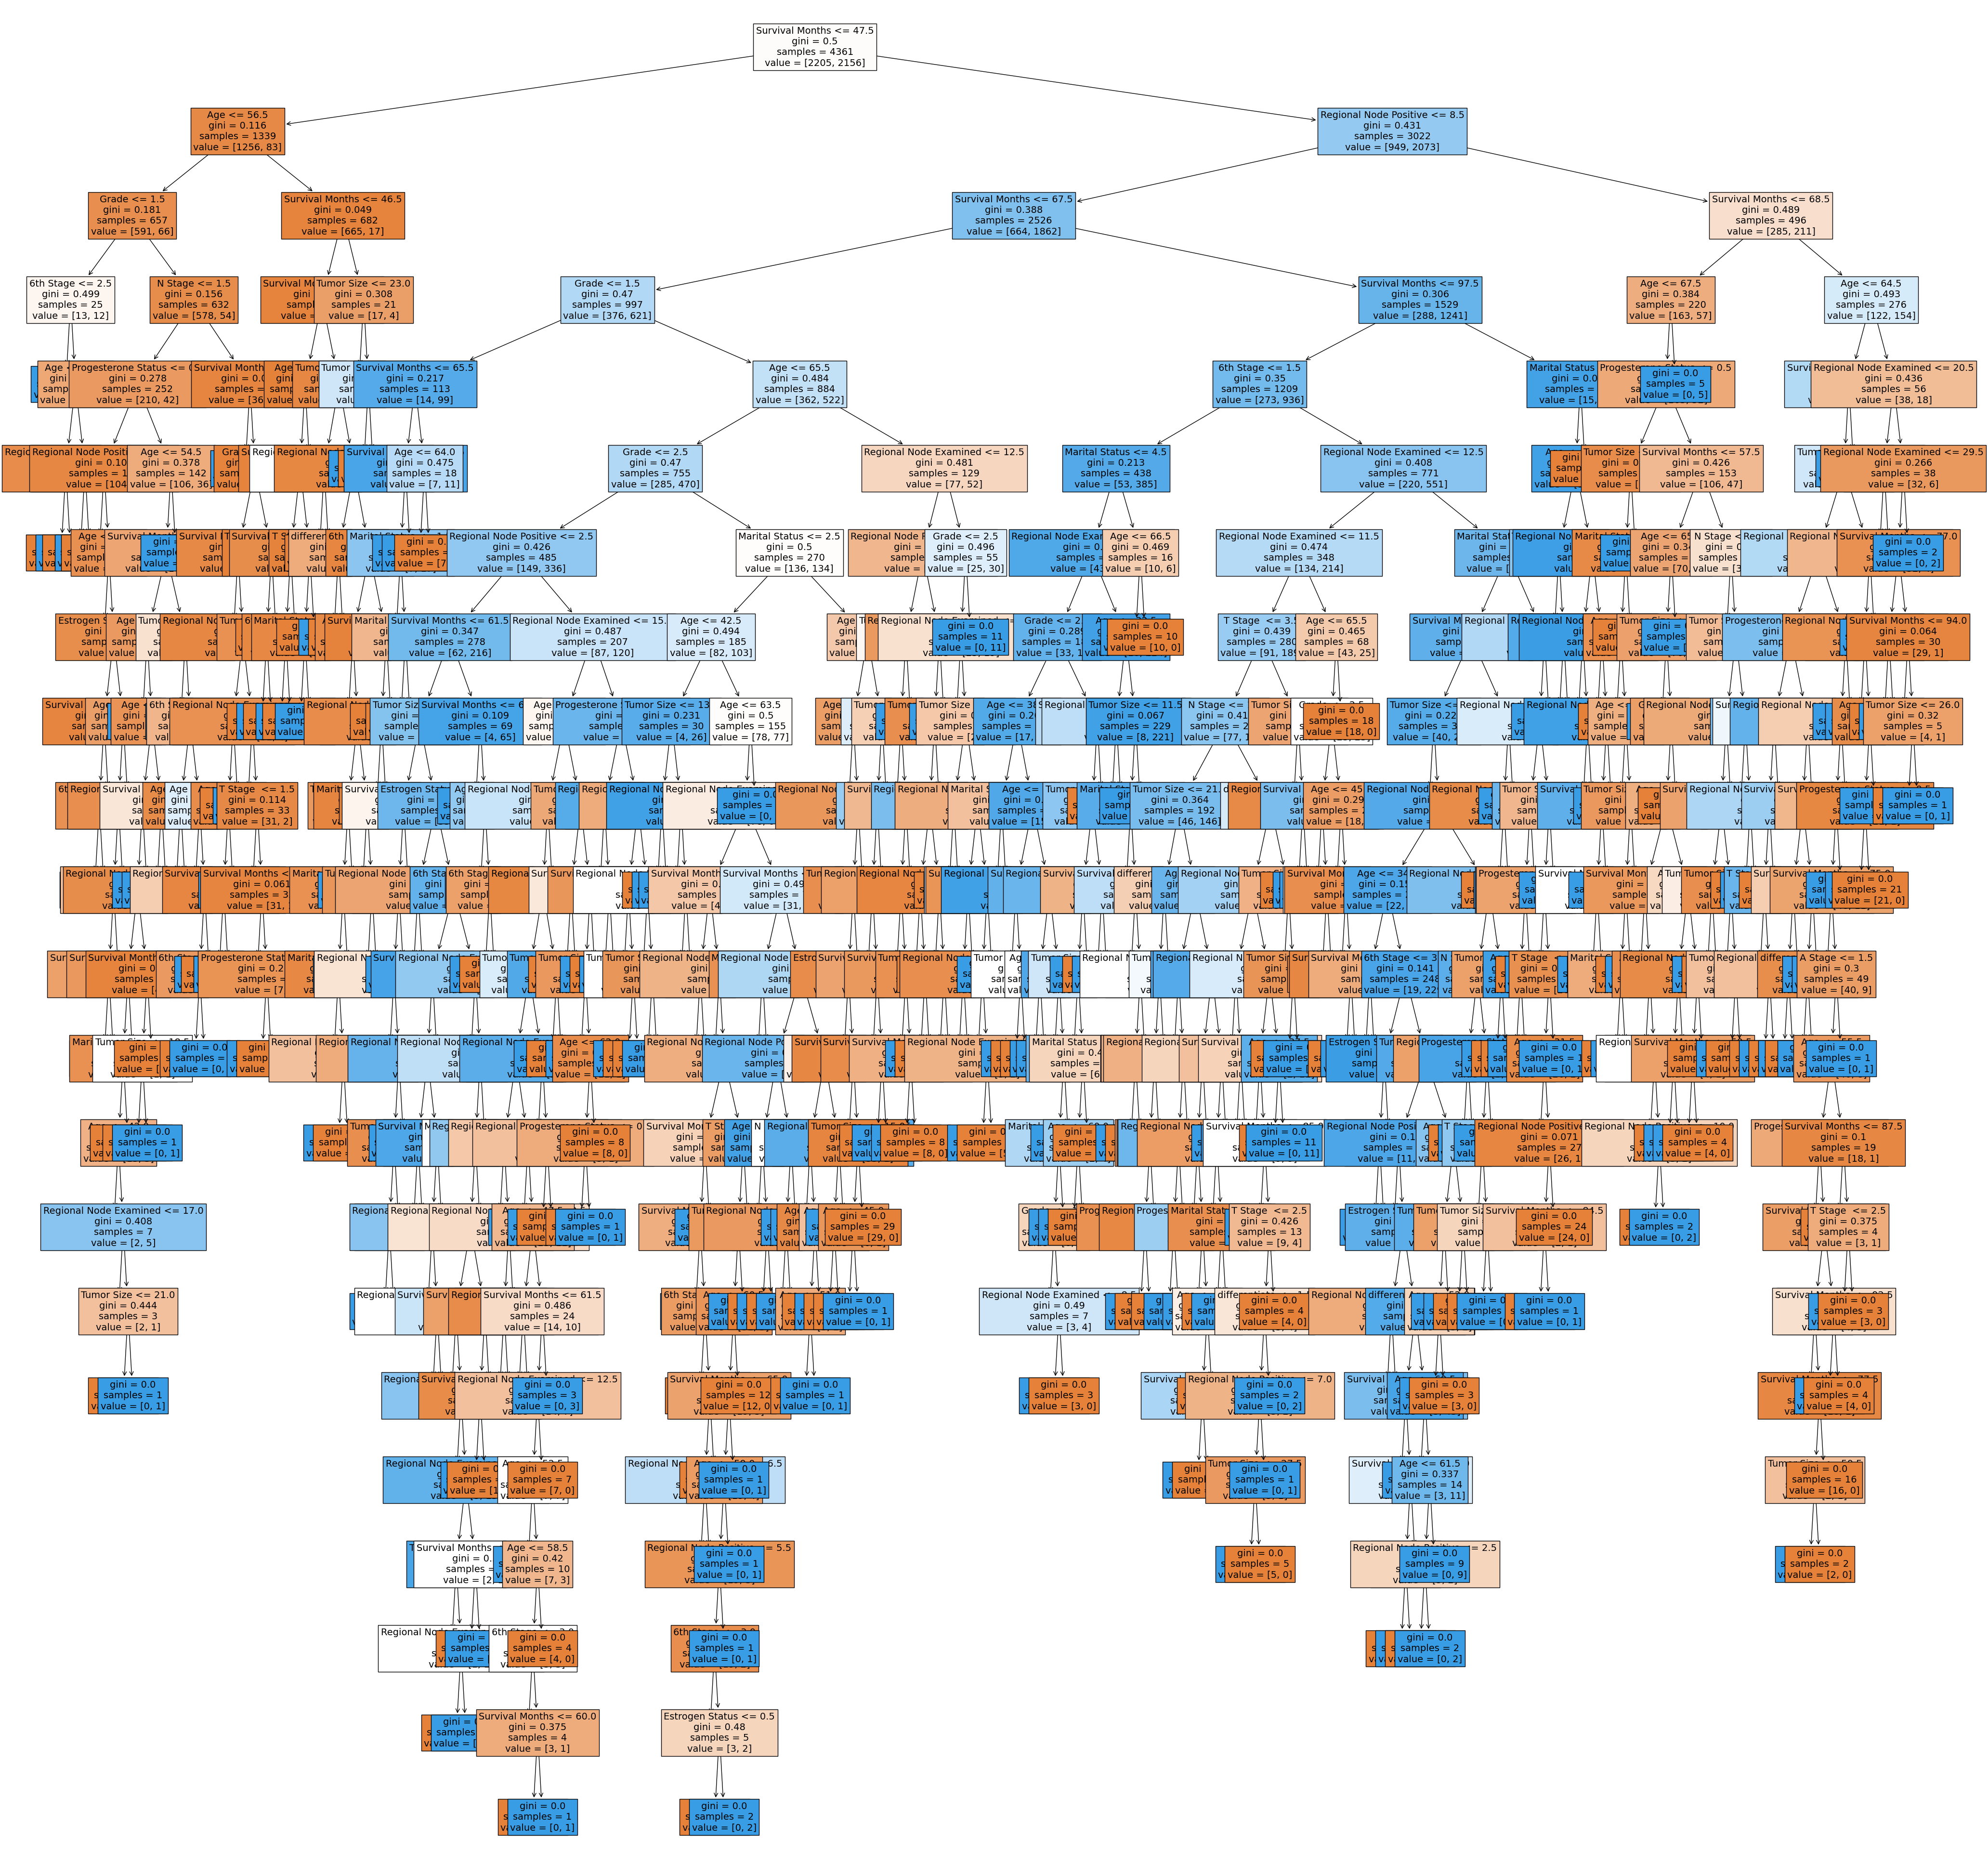

In [20]:
fig = plt.figure(figsize=(50,50))
tree.plot_tree(clf_gini, feature_names=X.columns, filled=True,fontsize=14)
plt.show()

Проход по сетке, даже не для хорошего аккураси, а просто посмотреть на какое-то небольшое дерево

In [21]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
params = {'max_depth': [2,3,4],
         'min_samples_split': [2,3,4,6,8],
         'min_samples_leaf': [1,2,4,6,8]}
clf = DecisionTreeClassifier(criterion='gini')
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 4, 6, 8],
                         'min_samples_split': [2, 3, 4, 6, 8]})

Train score 0.787663379958725
Val score 0.7983501374885427


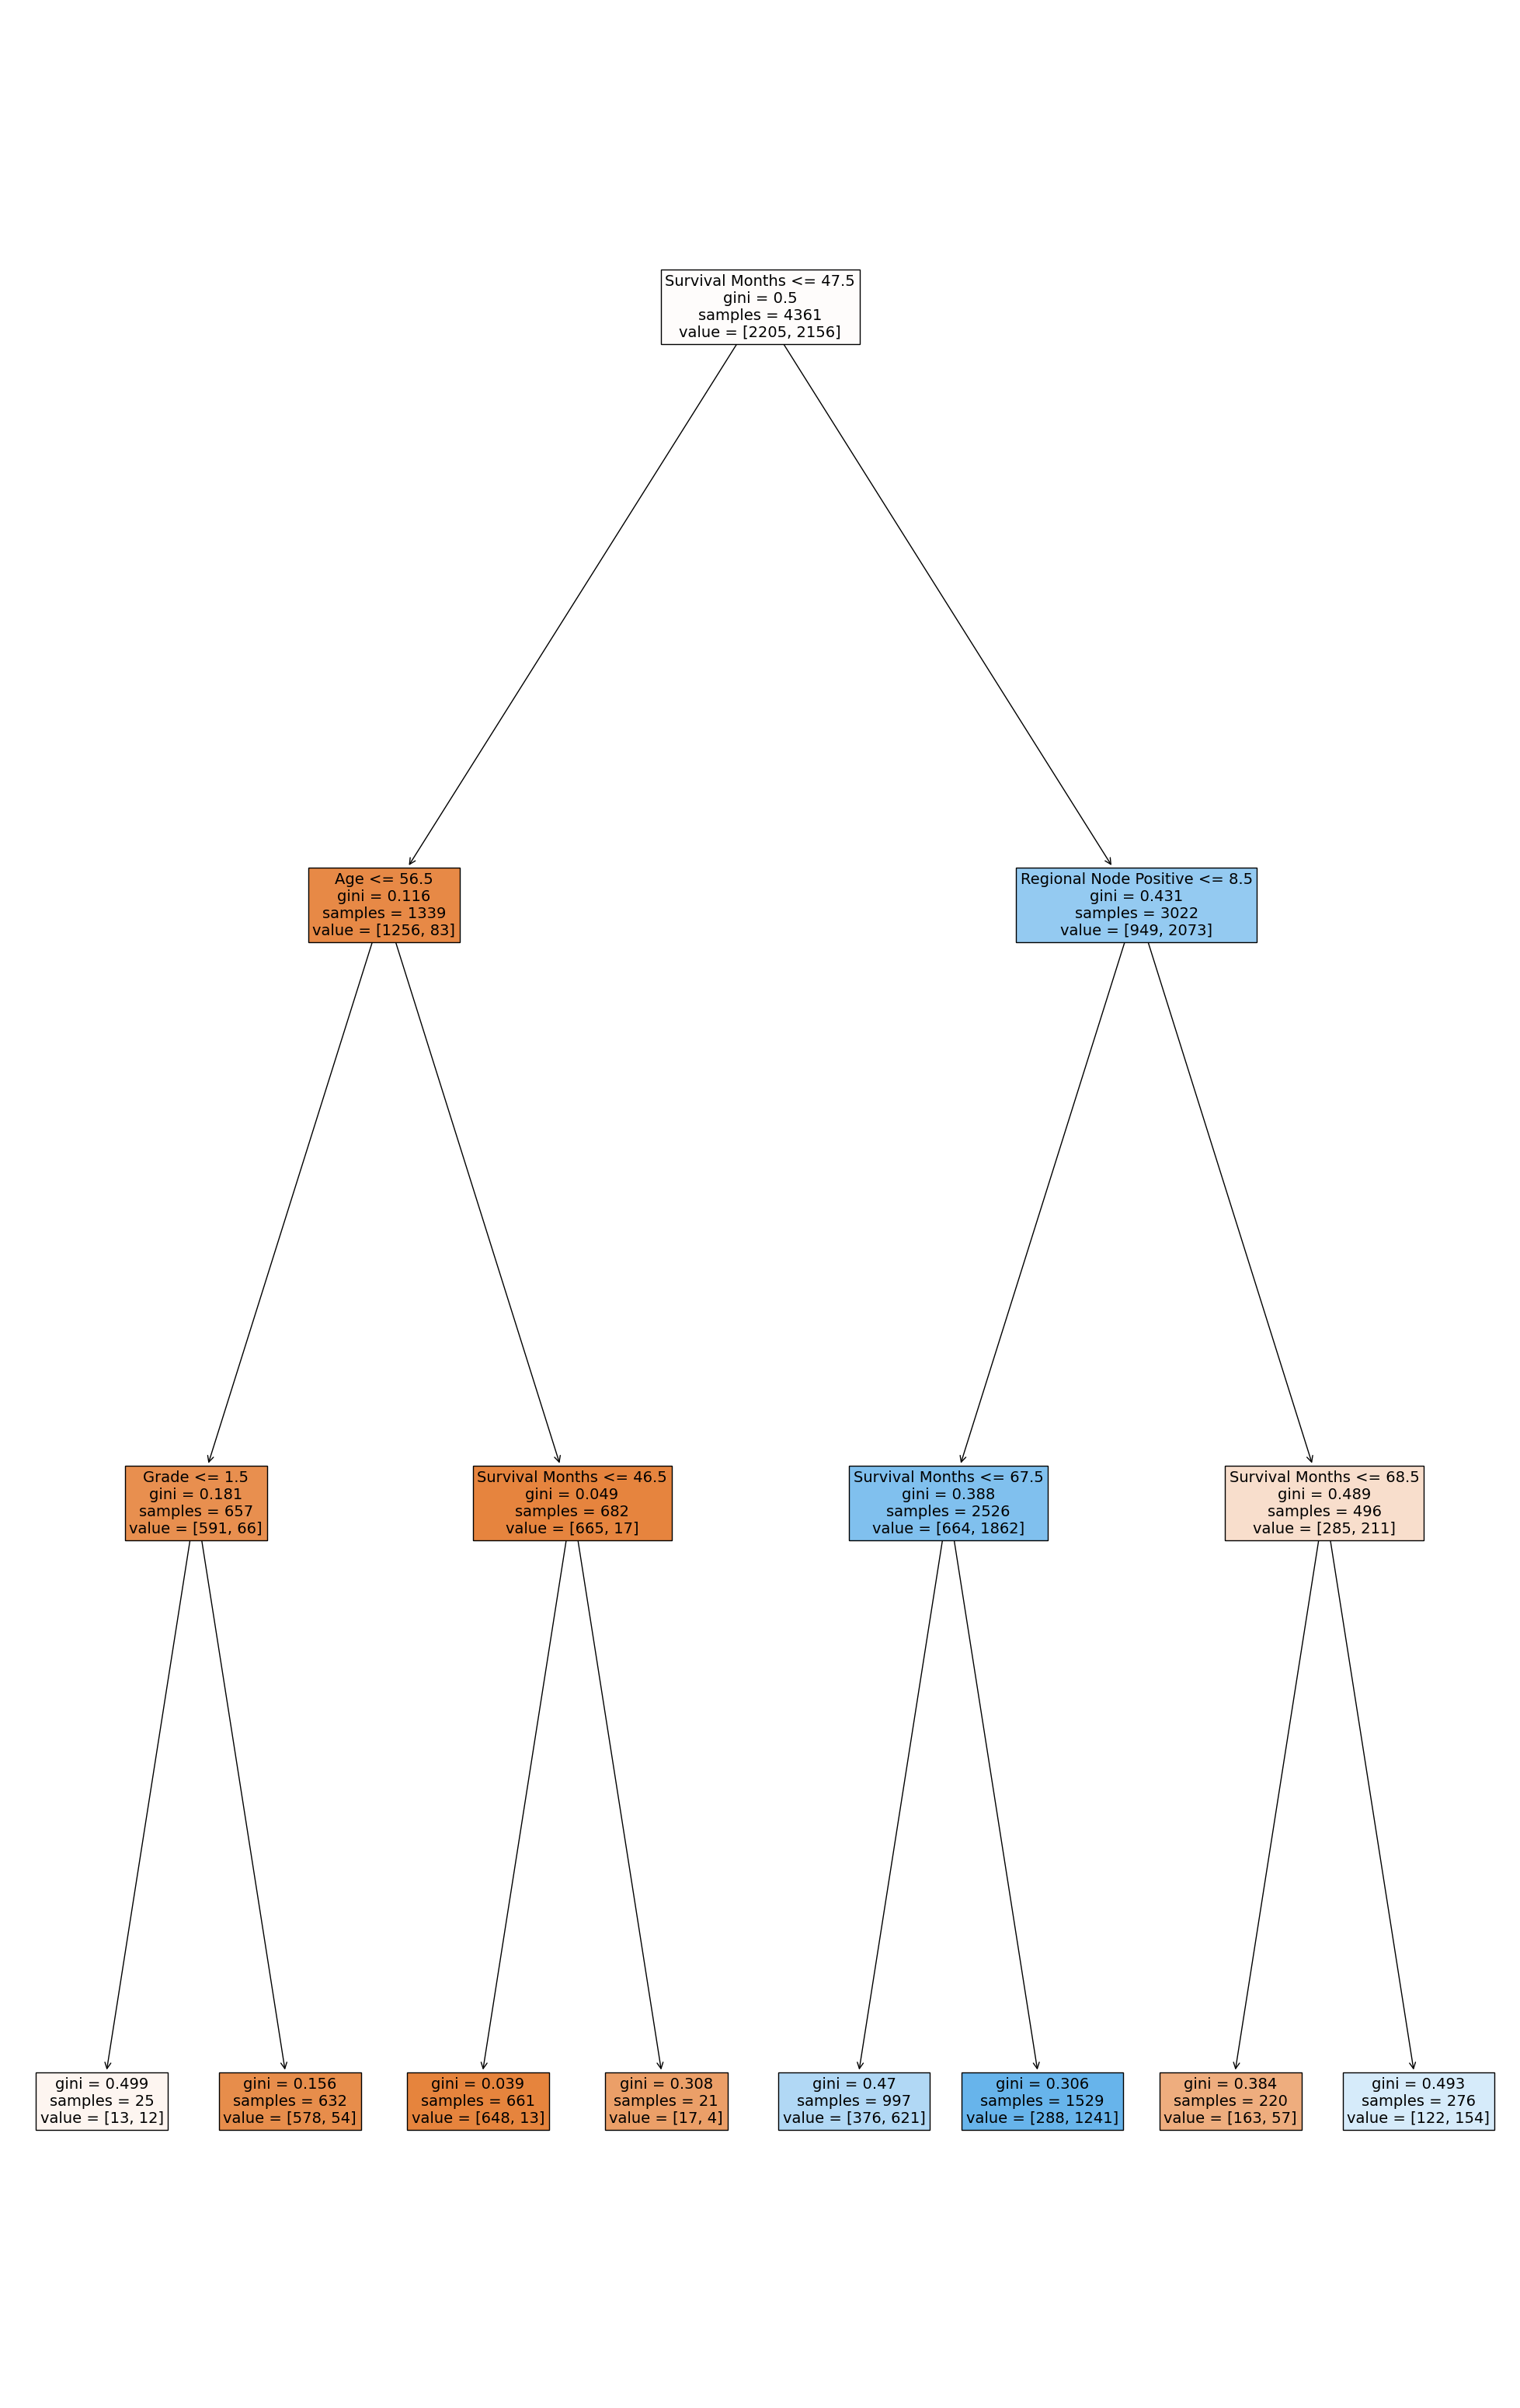

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [22]:
clf_gini=gcv.best_estimator_
clf_gini.fit(X_train,y_train)
y_pred_gini_train=clf_gini.predict(X_train)
y_pred_gini_val=clf_gini.predict(X_val)
print(f'Train score {accuracy_score(y_pred_gini_train,y_train)}')
print(f'Val score {accuracy_score(y_pred_gini_val,y_val)}')
fig = plt.figure(figsize=(25,40))
tree.plot_tree(clf_gini, feature_names=X.columns, filled=True,fontsize=14)
plt.show()
clf_gini.get_params()

In [23]:
conf_mat_val = metrics.confusion_matrix(y_val, y_pred_gini_val)
conf_mat_val = pd.DataFrame(conf_mat_val,index=["alive","dead"],columns=["alive","dead"])
print('gini conf mat val\n',conf_mat_val)
conf_mat_train = metrics.confusion_matrix(y_train, y_pred_gini_train)
conf_mat_train = pd.DataFrame(conf_mat_train,index=["alive","dead"],columns=["alive","dead"])
print('gini conf mat train \n',conf_mat_train)


gini conf mat val
        alive  dead
alive    346   173
dead      47   525
gini conf mat train 
        alive  dead
alive   1419   786
dead     140  2016


In [24]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00020637 0.0002102  0.0002102  0.00021293 0.00021293
 0.00021497 0.00021582 0.00021724 0.00021724 0.00021784 0.00022049
 0.00022081 0.0002214  0.00022166 0.00022214 0.00022256 0.00022294
 0.00022397 0.00022432 0.00022692 0.00022729 0.00022731 0.00022801
 0.00022838 0.00022931 0.00027356 0.00027573 0.00027795 0.00029902
 0.00030568 0.00030574 0.00030574 0.00030574 0.00030574 0.00030574
 0.00030574 0.00030574 0.0003175  0.00032103 0.00032344 0.00032736
 0.00033353 0.00033394 0.00034005 0.00034396 0.00034396 0.00034396
 0.00034942 0.00035572 0.00036034 0.00036689 0.00036689 0.00036689
 0.00036689 0.00037523 0.00037768 0.000381   0.00038218 0.00038218
 0.00038218 0.00039103 0.00039309 0.00039309 0.00039309 0.00039398
 0.00039594 0.00039607 0.00040014 0.00040128 0.00040128 0.00040128
 0.00040765 0.00040765 0.00041275 0.00041423 0.00041692 0.00041735
 0.00042039 0.00042039 0.00042039 0.00042188 0.00042333 0.00042333
 0.00042333 0.00042661 0.00042804 0.00043097 0.00043429 0.0004

COST PRUNING TREE из презентации

In [25]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

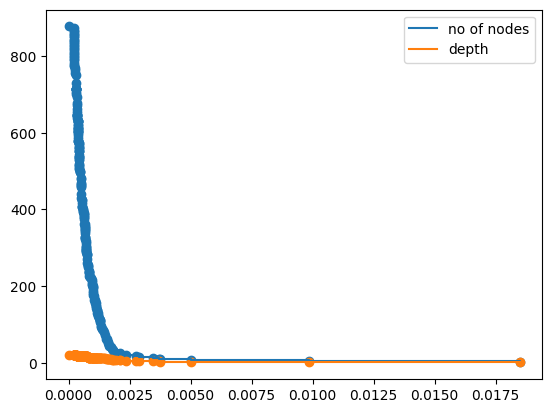

In [26]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

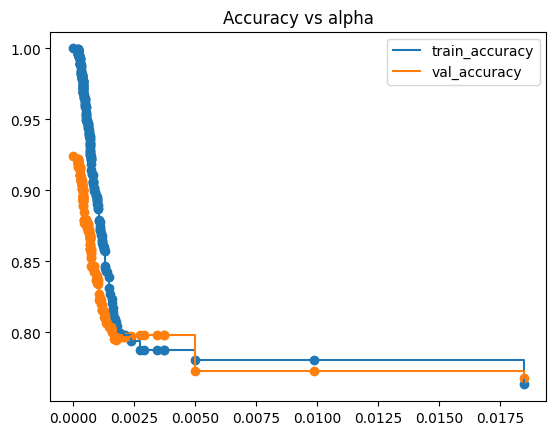

In [27]:
train_acc = []
val_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_val_pred = c.predict(X_val)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    val_acc.append(accuracy_score(y_val_pred,y_val))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,val_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,val_acc,label='val_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [28]:
clf_ = tree.DecisionTreeClassifier(random_state=1,ccp_alpha=0.001)
clf_.fit(X_train,y_train)
y_train_pred_prun = clf_.predict(X_train)
y_val_pred_prun = clf_.predict(X_val)
y_test_pred_prun=clf_.predict(X_test)
print(f'Train score {accuracy_score(y_train_pred_prun,y_train)}')
print(f'val score {accuracy_score(y_val_pred_prun,y_val)}')


Train score 0.8924558587479936
val score 0.8395967002749771


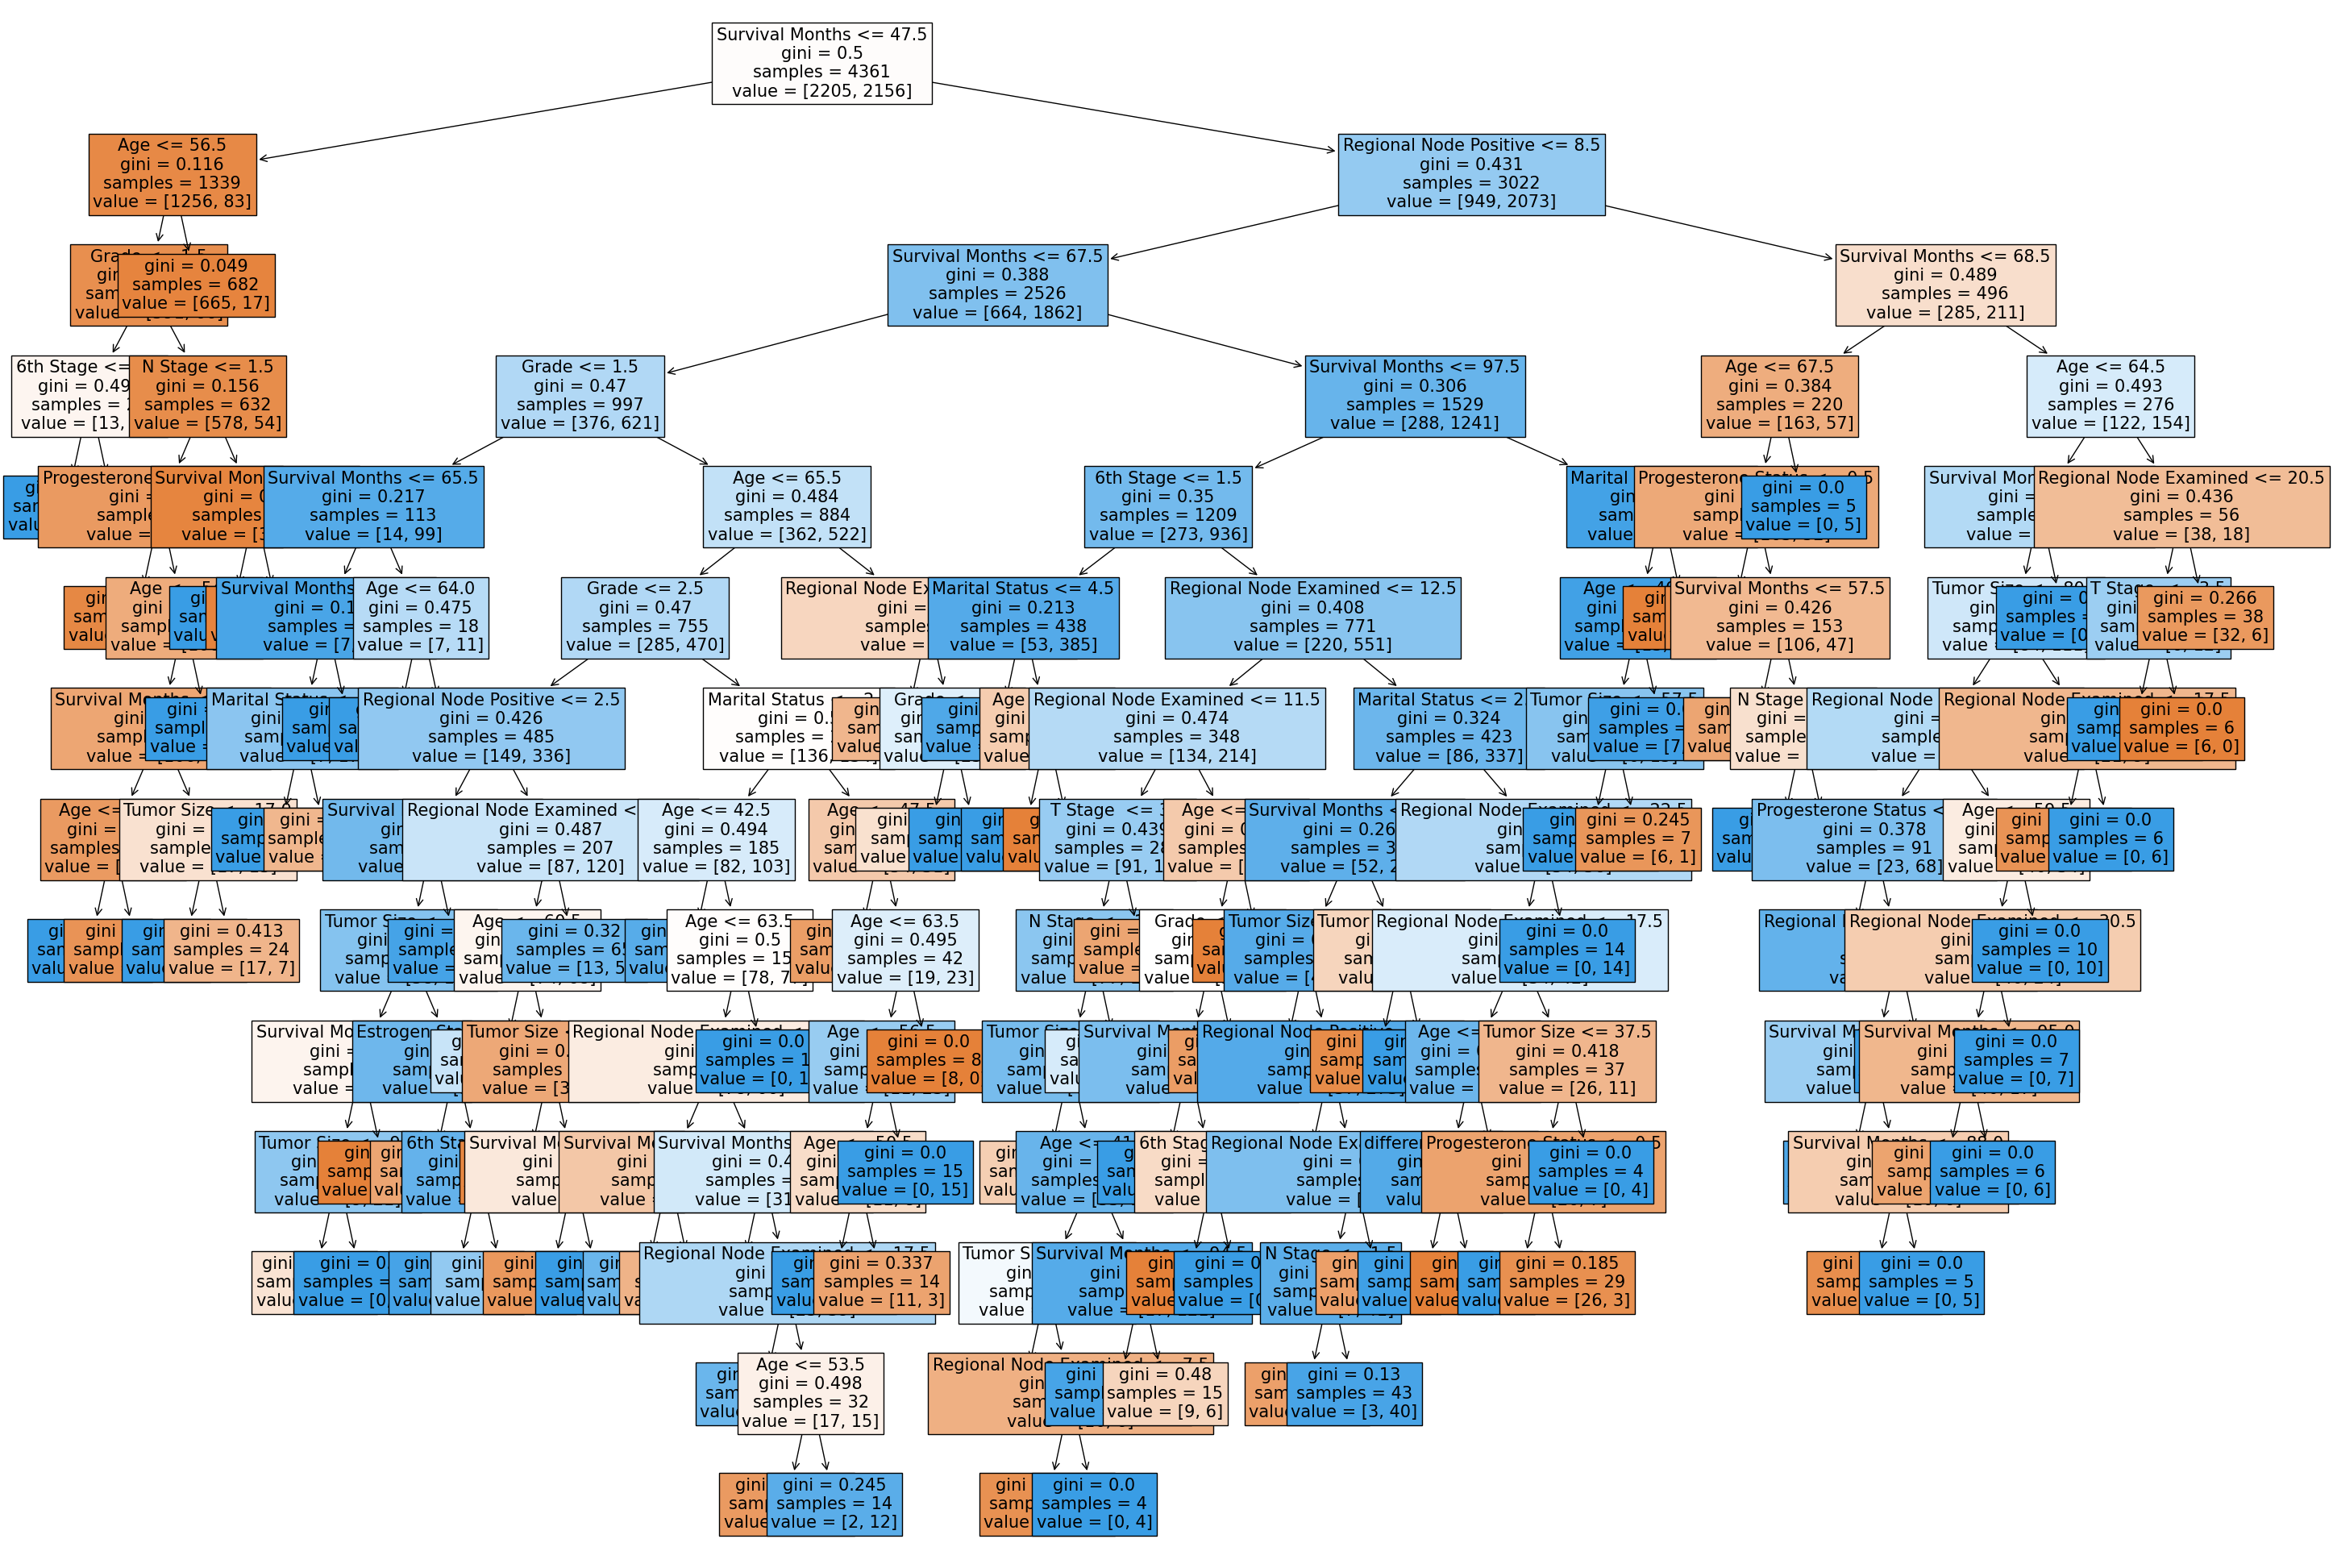

{'ccp_alpha': 0.001,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [29]:
fig = plt.figure(figsize=(35,25))
tree.plot_tree(clf_, feature_names=X.columns, filled=True,fontsize=15)
plt.show()
clf_.get_params()

In [30]:
print('Val score: {0:0.4f}'. format(accuracy_score(y_val, y_val_pred_prun)))
print(f'Train score {accuracy_score(y_train,y_train_pred_prun)}')
print('Test score: {0:0.4f}'. format(accuracy_score(y_test, y_test_pred_prun)))
conf_mat_val = metrics.confusion_matrix(y_val, y_val_pred_prun)
conf_mat_val = pd.DataFrame(conf_mat_val,index=["alive","dead"],columns=["alive","dead"])
print('gini conf mat val\n',conf_mat_val)
conf_mat_train = metrics.confusion_matrix(y_train, y_train_pred_prun)
conf_mat_train = pd.DataFrame(conf_mat_train,index=["alive","dead"],columns=["alive","dead"])
print('gini conf mat train \n',conf_mat_train)
conf_mat_test = metrics.confusion_matrix(y_test, y_test_pred_prun)
conf_mat_test = pd.DataFrame(conf_mat_test,index=["alive","dead"],columns=["alive","dead"])
print('gini conf mat test\n',conf_mat_test)

Val score: 0.8396
Train score 0.8924558587479936
Test score: 0.8578
gini conf mat val
        alive  dead
alive    445    74
dead     101   471
gini conf mat train 
        alive  dead
alive   1976   229
dead     240  1916
gini conf mat test
        alive  dead
alive    601    83
dead     111   569
